In [329]:
#Import of all the necessary packages

import numpy as np
import random
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm # Progress bar for loops
import networkx as nx # Tools to construct graphs and sample adjacency matrices
import scipy
import os # To save the arrays we create


In [442]:
# Definition of the variables for our system

# Hyperparameters
d = 10**2 # Dimension of our system
alpha = 10**6  # Inverse strength of the regularizer in our loss function
sigma = 10**0  # Variance of the noise sampled
time = 20  # Study the evolution of our model for 'time' timesteps
beta = 1  # Number of measures taken between each timestep for smooth visualization
taverage = 2 * 10**3 # Number of iterations averaged for the autocorrelation matrix

# NetworkX parameters
Nedges = 1.4  # Average number of edges leaving a node


In [443]:
# Sampling on an Erdős-Rényi graph. We add a random weight between 0.1 and 1 to every edge created.
# Then, we check the eigenvalues of the adjacency matrix and rescale it so that the spectral radius is equal to 0.9,
# implying convergence in our model.

def weightedsampling(d, Nedges, drawing="no"):
    """
    Generate a weighted Erdős-Rényi graph and rescale the adjacency matrix.

    Parameters:
    d (int): Dimension of the system (number of nodes).
    Nedges (float): Average number of edges leaving a node.
    drawing (str): Flag to determine if the graph should be drawn ('yes' or 'no').

    Returns:
    np.ndarray: Rescaled adjacency matrix.
    networkx.DiGraph: graph linked to the adjacency matrix.
    """
    p = Nedges / d  # Calculate edge creation probability
    print("Sampling of the graph")
    
    G = nx.erdos_renyi_graph(d, p, directed=True)  # Generate Erdős-Rényi graph
    
    for u, v in G.edges():
        G.edges[u, v]['weight'] = random.uniform(0.1, 1.0)  # Assign random weights to edges
    
    R = nx.to_numpy_array(G)  # Convert graph to adjacency matrix

    eigenvalues = np.linalg.eigvals(R)
    R = 0.9 / max(np.absolute(eigenvalues)) * R  # Set the spectral radius to 0.9
    
    # Reconstruct graph if required
    if drawing == "no":
        G_reconstructed = np.identity(d)
    else:
        G_reconstructed = nx.from_numpy_array(R, create_using=nx.DiGraph)
    
    print(G)
    return R, G_reconstructed

# Drawing of the graph. The small links do not get drawn.

def draw_graph(G, pos='helper', ax=None, node_size=800, node_color='skyblue', font_size=10, font_color='black',
               edge_color='gray', edge_width=2.5, edge_alpha=0.8, threshold=0.02):
    """
    Draw the given graph with custom visual settings. residual links below a certain thresold do not get
    drawn.

    Parameters:
    G (networkx.DiGraph): The graph to be drawn.
    pos (dict or str): Node positions. If 'helper', generate positions using spring layout.
    ax (matplotlib.axes.Axes): Matplotlib Axes object to draw on.
    node_size (int): Size of the nodes.
    node_color (str): Color of the nodes.
    font_size (int): Font size of node labels.
    font_color (str): Font color of node labels.
    edge_color (str): Color of the edges.
    edge_width (float): Width of the edges.
    edge_alpha (float): Transparency of the edges.
    threshold (float): Threshold to determine which edges to draw based on weight.

    Returns:
    dict: Positions of the nodes.
    """
    spread_factor = 10  # Just for the graph to look better :-)
    
    if pos == 'helper':  # Generate positions of the nodes in the graph if not provided
        pos = nx.spring_layout(G, k=spread_factor / np.sqrt(len(G.nodes())))
    
    # Draw nodes with customizations
    nx.draw_networkx_nodes(G, pos, node_color=node_color, node_size=node_size, edgecolors='black', linewidths=1, ax=ax)
    
    # Draw edges only if the weight is above the threshold
    for u, v, d in G.edges(data=True):
        if abs(d['weight']) > threshold:
            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=edge_width, edge_color=edge_color, alpha=edge_alpha, arrows=True, arrowsize=15, ax=ax)
            nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): "{:.2f}".format(d['weight'])}, font_size=font_size, font_color=font_color, ax=ax)
    
    # Draw node labels
    nx.draw_networkx_labels(G, pos, font_size=font_size, font_color=font_color, ax=ax)
    
    ax.axis('off')  # Remove axis

    return pos


In [444]:
# Useful functions

def newR(R, d, beta):
    """
    Rescale the adjacency matrix for smoother process. beta is the number of points we compute 
    between two timesteps.
    X_{t+1} = (1 - 1/beta) * Id * X_t + 1/beta * f(X_t) generates X_{t+1} =
                                                [(1- 1/ \\beta) * Id + A / \\beta] X_t + \\sigma / \\beta \\xi_t

    Parameters:
    R (np.ndarray): Adjacency matrix.
    d (int): Dimension of the system.
    beta (float): Damping parameter.

    Returns:
    np.ndarray: Rescaled adjacency matrix.
    """
    return (1 - 1 / beta) * np.identity(d) + R / beta


def power(R, time, d):
    """
    Compute the list of powers of a matrix.

    Parameters:
    R (np.ndarray): Adjacency matrix.
    time (int): Number of timesteps.
    d (int): Dimension of the system.

    Returns:
    np.ndarray: List of matrix powers.
    """
    list_power = np.zeros((time, d, d))
    list_power[0] = np.identity(d)
    for i in range(1, time):
        list_power[i] = list_power[i - 1] @ R
    return list_power

def sumpower(R, time, d):
    """
    Compute the sum of the powers of the matrix squared. This is used in the variance term of the 
    Random Matrix formalism.

    Parameters:
    R (np.ndarray): Adjacency matrix.
    time (int): Number of timesteps.
    d (int): Dimension of the system.

    Returns:
    tuple: Sum of powers and list of powers of the matrix.
    """
    sum_power = np.zeros((time, d, d))
    list_power = power(R, time, d)
    sum_power[0] = np.identity(d)
    for i in range(1, len(list_power)):
        sum_power[i] = sum_power[i - 1] + list_power[i] @ np.transpose(list_power[i])
    return sum_power, list_power

def solvediscretelyapunov(A, sigma, beta, tol=1e-15, max_iter=1000):
    """
    Solve the discrete Lyapunov equation.
    C0 = \\sigma^2 / \\beta^2 \\sum_{k=0}^{+ \infty} A^k A^k^\\top
    
    Parameters:
    A (np.ndarray): System matrix.
    sigma (float): Noise variance.
    beta (float): Damping parameter.
    tol (float): Tolerance for convergence.
    max_iter (int): Maximum number of iterations.

    Returns:
    np.ndarray: Solution to the Lyapunov equation.
    """
    A0 = A
    current_sum = np.identity(len(A[0]))
    
    for k in range(max_iter):
        term = A @ A.T
        A = A @ A0
        current_sum += term
        if np.linalg.norm(term, ord='fro') < tol:
            print("Number of terms in the sum to compute C0 =", k)
            break
    return (sigma ** 2 / beta ** 2) * current_sum

def theoreticalcovariance(R, time, d, sigma, beta):
    """
    Compute the theoretical autocorrelation matrices of the vector autoregressive model of order 1.

    Parameters:
    R (np.ndarray): Adjacency matrix.
    time (int): Number of timesteps.
    d (int): Dimension of the system.
    sigma (float): Noise variance.
    beta (float): Damping parameter.

    Returns:
    np.ndarray: List of theoretical autocorrelation matrices.
    """
    Cth = np.zeros((beta * time, d, d))
    Cth[0] = solvediscretelyapunov(R, sigma, beta)
    for i in range(1, beta * time):
        Cth[i] = R @ Cth[i - 1]
    return Cth

def autocorrelationtime(Cth, time, beta, max_iter=1000, tol=1e-15):
    """
    Compute the autocorrelation time and effective sample size of the vector autoregressive model of order 1..

    Parameters:
    Cth (np.ndarray): List of theoretical autocorrelation matrices.
    time (int): Number of timesteps.
    beta (float): Damping parameter.
    max_iter (int): Maximum number of iterations.
    tol (float): Tolerance for convergence.

    Returns:
    tuple: Autocorrelation time and effective sample size.
    """
    print("Computation of the autocorrelation time of our process")
    lambdamaxlist = [np.real(max(np.linalg.eigvals(Cth[0])))]
    threshold = lambdamaxlist[0] / np.exp(1)
    autocorrtime = 0
    sumautocorr = 0
    
    for i in range(1, beta * time):
        lambdamaxlist.append(np.real(max(np.linalg.eigvals(Cth[i]))))
        if threshold < lambdamaxlist[i - 1] and threshold > lambdamaxlist[i]:
            autocorrtime = i
            break
    print("Autocorrelation time of the process =", autocorrtime)
    
    f = lambda x: lambdamaxlist[0] * np.exp(-x / autocorrtime)  # Fitted autocorrelation function
    
    for k in range(max_iter):
        addedterm = f(k * autocorrtime) / lambdamaxlist[0]
        sumautocorr += addedterm
        if addedterm < tol:
            break
    print("Due to correlations, the sample size has to be divided by", sumautocorr) # This value should always be the same
                                                                            #because we chose the correlation to be 1/e.
    return autocorrtime, sumautocorr

def convergence(R, sigma, beta, d, tconvergence=10**5):
    """
    Compute the convergence of the system to an attractor.

    Parameters:
    R (np.ndarray): Adjacency matrix.
    sigma (float): Noise variance.
    d (int): Dimension of the system.
    tconvergence (int): Number of timesteps for convergence.

    Returns:
    np.ndarray: Final state vector.
    """
    X0 = np.random.normal(0, sigma, size=(d, 1))
    for _ in tqdm(range(beta * tconvergence)):
        xi = np.random.normal(0, sigma, size=(d, 1))
        X0 = R @ X0 + xi
    return X0

def computationX(X, smallR, xi, taverage, time, beta):
    """
    Compute the whole trajectory X.

    Parameters:
    X (np.ndarray): Initial state vector.
    smallR (np.ndarray): Rescaled adjacency matrix.
    xi (np.ndarray): Noise matrix.
    taverage (int): Number of iterations to average.
    time (int): Number of timesteps.
    beta (float): Damping parameter.

    Returns:
    np.ndarray: Updated sample matrix.
    """
    for j in tqdm(range(1, taverage * beta)):
        X[j, :, :] = smallR @ X[j - 1, :, :] + xi[j - 1, :, :] / beta
    return X

def computationCt(X, taverage, time, autocorrtime, beta):
    """
    Compute the empirical correlation matrices.

    Parameters:
    X (np.ndarray): Sample matrix.
    xi (np.ndarray): Noise matrix.
    taverage (int): Number of iterations to average.
    time (int): Number of timesteps.
    autocorrtime (int): Autocorrelation time.
    beta (float): Damping parameter.

    Returns:
    np.ndarray: Empirical correlation matrices.
    """
    i = 0
    Ct = np.zeros((beta * time, d, d))
    for j in tqdm(range(beta * (taverage - time) - 1)):
        if j % autocorrtime == 0:
            i += 1
            for t in range(0, beta * time):
                Ct[t, :, :] += X[j + t, :, :] @ np.transpose(X[j, :, :])
    print("# of measures for Ct:", i)
    return Ct, i 

def saving(X, R, xi, d, Nedges, taverage, beta, base_directory=r"C:\Users\marchetta\Desktop\Stage\Results"):
    """
    Save the adjacency matrix and the measures found.

    Parameters:
    X (np.ndarray): Sample matrix.
    R (np.ndarray): Adjacency matrix.
    xi (np.ndarray): Noise matrix.
    d (int): Dimension of the system.
    Nedges (float): Average number of edges leaving a node.
    taverage (int): Number of iterations to average.
    beta (float): Damping parameter.
    base_directory (str): Base directory for saving files.
    """
    directory_name = f"matrixsize={d}_iterations={taverage}_averageconnectivity={Nedges}_measures_between_two_ts={beta}"
    full_directory_path = os.path.join(base_directory, directory_name)
    if not os.path.exists(full_directory_path): #create the file
        os.makedirs(full_directory_path)
    
    Xfilename = f"sample_of_matrixsize={d}_iterations={taverage}_averageconnectivity={Nedges}.npy"
    Rfilename = f"matrix_of_matrixsize={d}_averageconnectivity={Nedges}.npy"
    xifilename = f"noise_of_matrixsize={d}_averageconnectivity={Nedges}.npy"
    
    Xfile_path = os.path.join(full_directory_path, Xfilename)
    Rfile_path = os.path.join(full_directory_path, Rfilename)
    xifile_path = os.path.join(full_directory_path, xifilename)
    
    np.savez_compressed(Xfile_path, X)
    np.savez_compressed(Rfile_path, R)
    np.savez_compressed(xifile_path, xi)

def load_array(file_path):
    """
    Load data stored in npz format. This is a technical function to unpack the data, used in function loaddata.

    Parameters:
    file_path (str): Path to the npz file.

    Returns:
    np.ndarray: Loaded array.
    """
    with np.load(file_path) as data:
        array = data['arr_0']
    return array

def loaddata(d, Nedges, taverage, beta, base_directory=r"C:\Users\marchetta\Desktop\Stage\Results"):
    """
    Load previously generated data.

    Parameters:
    d (int): Dimension of the system.
    Nedges (float): Average number of edges leaving a node.
    taverage (int): Number of iterations to average.
    beta (float): Damping parameter.
    base_directory (str): Base directory for loading files.

    Returns:
    tuple: Sample matrix, adjacency matrix, and noise matrix.
    """
    directory_name = f"matrixsize={d}_iterations={taverage}_averageconnectivity={Nedges}_measures_between_two_ts={beta}"
    full_directory_path = os.path.join(base_directory, directory_name)
    
    Xfile_path = os.path.join(full_directory_path, f"sample_of_matrixsize={d}_iterations={taverage}_averageconnectivity={Nedges}.npy.npz")
    Rfile_path = os.path.join(full_directory_path, f"matrix_of_matrixsize={d}_averageconnectivity={Nedges}.npy.npz")
    xifile_path = os.path.join(full_directory_path, f"noise_of_matrixsize={d}_averageconnectivity={Nedges}.npy.npz")
    
    X = load_array(Xfile_path)
    R = load_array(Rfile_path)
    xi = load_array(xifile_path)
    
    return X, R, xi


In [445]:
def process(d, Nedges, alpha, time, taverage, sigma, beta, load="no", withsave="no", drawing="no"):
    """
    Process function to compute empirical correlation matrices, either by importing data or iterating the process from scratch.

    Parameters:
    d (int): Dimension of the system.
    Nedges (int): Average number of edges leaving a node.
    alpha (float): Hyperparameter contained in the loss function.
    time (int): Number of timesteps.
    taverage (int): Number of iterations to average.
    sigma (float): Noise variance.
    beta (float): Damping parameter.
    load (str): "yes" to load data, "no" to generate new data.
    withsave (str): "yes" to save the generated data, "no" otherwise.
    drawing (str): "yes" to draw the graph, "no" otherwise.

    Returns:
    tuple: Computed Rt, Ct, Cth, X, autocorrtime, R, G_reconstructed, Neff, Neffunco.
    """
    
    # Construction of arrays and convergence to an attractor of the system.
    if load == "no":
        X = np.zeros((beta * taverage, d, 1))
        xi = np.random.normal(0, sigma, size=(beta * taverage, d, 1))
        R, G_reconstructed = weightedsampling(d, Nedges, drawing)
        smallR = newR(R, d, beta)
        
        print("Convergence to a fixed point")
        X[0, :] = convergence(R, sigma, beta, d)
        
        print("Computation of the process")
        X = computationX(X, smallR, xi, taverage, time, beta)
    else:
        print("Import of the data")
        X, R, xi = loaddata(d, Nedges, taverage, beta)
        if drawing == "no":
            G_reconstructed = np.identity(d)
        else:
            G_reconstructed = nx.from_numpy_array(R, create_using=nx.DiGraph)
        print("Data imported")
    
    # Iteration of the process and computation of Ct for each t, averaged over taverage realizations.
    print("Computation of the theoretical autocorrelation matrix")
    Cth = theoreticalcovariance(smallR, 20, d, sigma, beta)
    autocorrtime, ratioeffectivesamplesize = autocorrelationtime(Cth, 20, beta)
    Cth = Cth[:beta * time, :, :]
    
    print("Computation of Ct")
    Ct, Neff = computationCt(X, taverage, time, autocorrtime, beta)
    Neffunco = Neff / ratioeffectivesamplesize #this is the number of totally uncorrelated measures one 
                                                    #can get in this process.
    
    print("Neff =", Neff)
    Ct = Ct / Neff
    
    Rt = np.zeros((beta * time, d, d))
    for i in range(beta * time):
        Rt[i, :, :] = alpha * Ct[i, :, :] @ np.linalg.inv(np.identity(d) + alpha * Ct[0, :, :])
    
    # Save the dataset
    if withsave != "no" and load == "no":
        print("Doing the save")
        saving(X, R, xi, d, Nedges, taverage, beta)
        print("Save successfully done")
    
    return Rt, Ct, Cth, X, autocorrtime, R, G_reconstructed, Neff, Neffunco


In [446]:
def drawing_of_process(Rt, Ct, Cth, R, G_reconstructed, alpha, beta, ax):
    """
    Plot the sampled Erdos-Renyi graph and the inferred one one next to each other.

    Parameters:
    Rt (np.ndarray): Inferred response matrices.
    Ct (np.ndarray): Empirical correlation matrices.
    Cth (np.ndarray): Theoretical correlation matrices.
    R (np.ndarray): Adjacency matrix of the sampled graph.
    G_reconstructed (networkx.DiGraph): Reconstructed graph from R.
    alpha (float): Scaling factor for Rt.
    beta (float): Damping parameter.
    ax (np.ndarray): Array of matplotlib axes for plotting.
    """
    # Compute the inferred adjacency matrix
    Rinfered = ((1 / beta - 1) * np.identity(len(Rt[1, 0, :])) + Rt[1, :, :]) * beta #to go back from smallR to R,
                                                                #this is useful if beta is larger than 1.
    Ginfered = nx.from_numpy_array(Rinfered, create_using=nx.DiGraph)
    
    # Count the number of edges with significant weight
    count = 0
    for u, v, d in Ginfered.edges(data=True):
        if d['weight'] > beta * 0.02:
            count += 1
    
    print("Number of edges plotted =", count)
    
    # Draw the true response graph
    print("Drawing of the true response")
    pos = drawing(G_reconstructed, ax=ax[0])
    
    # Compute the difference between the true and inferred adjacency matrices
    print("Drawing of the difference between the true response matrix and the inferred one")
    G_reconstructedar = nx.to_numpy_array(G_reconstructed)
    diff = G_reconstructedar - Rinfered
    diffG = nx.from_numpy_array(diff, create_using=nx.DiGraph)
    
    # Draw the difference graph
    pos = drawing(diffG, pos, ax=ax[1])
    
    # Adjust plot margins for better spacing
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)
    
    # Uncomment the following line to save the plot as a PNG file
    # plt.savefig(f'graph_alpha_{alpha}.png')
    plt.show()



In [447]:
def selfenergy(h, alpha):
    """
    Compute the self-energy \Lambda of the system.

    Parameters:
    - h (float): Parameter found in the fixed point process.
    - alpha (float): Hyperparameter contained in the loss function.

    Returns:
    - float: The self-energy value.
    """
    return alpha / (1 + h)

def compute_bias(Rlistpower, G, time, alpha, d):
    """
    Compute the bias term for the theoretical response function.
    
    
    /!\ BE CAREFUL /!\
    This formula is not exactly right, since I do not take into account the factor \frac{\partial \Lambda}{\partial \alpha}
    that comes out when one faces a power of the resolvent, which is a Random Matrix. See the report for more info
    /!\ BE CAREFUL /!\
    
    Parameters:
    - Rlistpower (ndarray): List of powers of the system matrix R.
    - G (ndarray): Resolvent matrix.
    - time (int): Number of time steps.
    - alpha (float): Interaction strength parameter.
    - d (int): Dimension of the system.

    Returns:
    - ndarray: The bias term matrix for each time step.
    """
    helperbias = np.zeros((time, d, d))
    bias = np.zeros((time, d, d))
    print("Computation of the bias term")
    
    for t in range(time):
        helperbias[t] = Rlistpower[t] @ (np.identity(d) - G)
    
    for t in tqdm(range(time)):
        for i in range(d):
            for j in range(d):
                bias[t, i, j] = helperbias[t, i, j] ** 2
                
    return bias

def compute_variance(Rsumpower, G, time, d):
    """
    Compute the variance term for the theoretical response function.
    
    /!\ BE CAREFUL /!\
    This formula is not exactly right, since I do not take into account the factor \frac{\partial \Lambda}{\partial \alpha}
    that comes out when one faces a power of the resolvent, which is a Random Matrix. See the report for more info
    /!\ BE CAREFUL /!\

    Parameters:
    - Rsumpower (ndarray): Sum of powers of the system matrix R.
    - G (ndarray): Resolvent matrix.
    - time (int): Number of time steps.
    - d (int): Dimension of the system.

    Returns:
    - ndarray: The variance term matrix for each time step.
    """
    variance = np.zeros((time, d, d))
    helper = G @ (np.identity(d) - G)
    print("Computation of the variance term")
    
    for t in tqdm(range(time)):
        for i in range(d):
            for j in range(d):
                variance[t, i, j] = Rsumpower[t, i, i] * helper[j, j]
                
    return variance

def fixed_point_iteration(Cth, rho, alpha, initial_guess, tol, max_iter):
    """
    Perform fixed-point iteration to find the renormalized coefficient alpha, that we call self-energy.

    Parameters:
    - Cth (ndarray): Population matrix.
    - rho (float): Inverse parameter of the Marchenko-Pastur distribution.
    - alpha (float): Hyperparameter contained in the loss function.
    - initial_guess (float): Initial guess for the fixed point. This should always be smaller than alpha.
    - tol (float): Tolerance for convergence.
    - max_iter (int): Maximum number of iterations.

    Returns:
    - float: The converged self-energy value.
    - float: The final value of the fixed point.
    """
    eigenvalues = np.real(np.linalg.eigvals(Cth))
    listh = []
    h_new = initial_guess
    listh.append(h_new)
    
    for ts in range(max_iter):
        h_old = copy.deepcopy(h_new)
        selfe = selfenergy(h_old, alpha)
        h_new = 0
        
        for eigenvalue in eigenvalues:
            h_new += alpha / (rho * len(eigenvalues)) * eigenvalue * (1 + selfenergy(h_old, alpha) * eigenvalue) ** (-1)
        
        if abs(h_new - h_old) < tol:
            selfe = selfenergy(h_new, alpha)
            print("h final =", h_new)
            print("selfenergy =", selfe)
            print("ratio self-energy / alpha =", selfe / alpha)
            return selfe, h_new
        
        listh.append(h_new)
        
    selfe = selfenergy(h_new, alpha)
    print("Warning: Maximum number of iterations reached.")
    print("h final =", h_new)
    print("selfenergy =", selfe)
    print("Ratio self-energy / alpha =", selfe / alpha)
    
    return selfe, h_new

def resolvent(C, alpha, d):
    """
    Compute the resolvent matrix.

    Parameters:
    - C (ndarray): Population matrix.
    - alpha (float): Hyperparameter contained in the loss function.
    - d (int): Dimension of the system.

    Returns:
    - ndarray: The resolvent matrix.
    """
    return np.linalg.inv(np.identity(d) + alpha * C)

def RMTempiricalresponse(Cth, R, rho, alpha, time, Neff, d, sigma, beta, initial_guess=alpha / 10000, tol=1e-15, max_iter=10000):
    """
    Compute the empirical response function using Random Matrix Theory.

    Parameters:
    - Cth (ndarray): Theoretical covariance matrix.
    - R (ndarray): System matrix.
    - rho (float): Inverse parameter of the Marchenko-Pastur distribution.
    - alpha (float): Hyperparameter contained in the loss function.
    - time (int): Number of time steps.
    - Neff (float): Effective number of samples.
    - d (int): Dimension of the system.
    - sigma (float): Noise strength parameter.
    - beta (float): Time scaling parameter.
    - initial_guess (float): Initial guess for the fixed point iteration.
    - tol (float): Tolerance for convergence.
    - max_iter (int): Maximum number of iterations.

    Returns:
    - tuple:
        - RTrmt (ndarray): The empirical response function.
        - bias (ndarray): The bias term matrix for each time step.
        - variance (ndarray): The variance term matrix for each time step.
    """
    smallR = newR(R, d, beta)
    print("Computation of the theoretical covariance")
    
    Rsumpower, Rlistpower = sumpower(smallR, beta * time, d)
    helperbias = np.zeros((beta * time, d, d))
    bias = np.zeros((beta * time, d, d))
    variance = np.zeros((beta * time, d, d))
    
    print("Fixed point convergence")
    selfe, _ = fixed_point_iteration(Cth[0], rho, alpha, initial_guess, tol, max_iter)
    
    print("Computation of bias and variance term")
    print('renormalized alpha =', selfe)
    
    G = resolvent(Cth[0], selfe, d)
    bias = compute_bias(Rlistpower, G, beta * time, alpha, d)
    variance = compute_variance(Rsumpower, G, beta * time, d)
    variance = sigma ** 2 * alpha / (beta ** 2 * Neff) * variance
    
    RTrmt = bias + variance
    return RTrmt, bias, variance


#this formula is the one without going to the random matrix formalism.
#def RMTempiricalresponseBIS(Ct, R, alpha, time, Neff, d, sigma = 1):
#    print("Computation of the theoretical covariance")
#    Rsumpower, Rlistpower = sumpower(R,time,d)
#    helperbias = np.zeros((time,d,d))
#    bias = np.zeros((time,d,d))
#    variance = np.zeros((time,d,d))
#    print("Computation of bias and variance term")
#    G = resolvent(Ct[0], alpha,d)
#    bias = compute_bias(Rlistpower,G, time, alpha,d)
#    variance = compute_variance(Rsumpower, G, time, d)
#    variance = alpha * sigma / Neff * variance 
#    RTrmt = bias + variance
#    return (RTrmt, bias, variance)


In [448]:
def computation_responses(d, Nedges, alpha, time, taverage, sigma, beta, load="no", withsave="no", drawing="no"):
    """
    Metafunction that construct the response matrices both empirical and with RMT. You can also choose to display
    the underlying graph and the inferred one.
    
    /!\ BE CAREFUL /!\
    If an error occurs, it may indicate that the sampled graph does not have the desired characteristics
    (e.g., eigenvalues). In such cases, stop and relaunch the process.
    /!\ BE CAREFUL /!\
    
    Parameters:
    - d (int): Dimension of the system.
    - Nedges (int): Number of edges in the graph.
    - alpha (float): Interaction strength parameter.
    - time (int): Total number of time steps.
    - taverage (int): Time over which averaging is performed.
    - sigma (float): Noise strength parameter.
    - beta (float): Time scaling parameter.
    - load (str): Option to load existing data, either "yes" or "no". Default is "no".
    - withsave (str): Option to save the computed results, either "yes" or "no". Default is "no".
    - drawing (str): Option to draw the graphs, either "yes" or "no". Default is "no".

    Returns:
    - RTcorr (ndarray): empirical response matrix.
    - Ct (ndarray): empirical correlation matrices.
    - Cth (ndarray): Theoretical correlation matrices.
    - R (ndarray): Adjacency matrix.
    - G_reconstructed (networkx.Graph): Reconstructed graph from the data.
    - Neff (float): Effective number of samples after accounting for autocorrelation.
    - Neffunco (float): Number of samples totally uncorrelated.
    - RTrmt (ndarray): Theoretical response matrix using RMT.
    - bias (ndarray): Bias components of the response.
    - variance (ndarray): Variance components of the response.
    """
    # Run the process to compute various matrices and graph information
    RTcorr, Ct, Cth, X, autocorrtime, R, G_reconstructed, Neff, Neffunco = process(
        d, Nedges, alpha, time, taverage, sigma, beta, load, withsave, drawing
    )

    # If drawing option is enabled, plot the graphs
    if drawing != "no":
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        drawing_of_process(RTcorr, Ct, Cth, R, G_reconstructed, alpha, beta, ax=axes)

    # Compute the ratio of effective number of samples to the dimension
    rho = Neff / d
    print("Ratio # of measures / dimension =", rho)

    # Calculate the response using RMT
    RTrmt, bias, variance = RMTempiricalresponse(Cth, R, rho, alpha, time, Neff, d, sigma, beta)

    return RTcorr, Ct, Cth, R, G_reconstructed, Neff, Neffunco, RTrmt, bias, variance

# Execute the function with specified parameters
RTcorr, Ct, Cth, R, G_reconstructed, Neff, Neffunco, RTrmt, bias, variance = computation_responses(
    d, Nedges, alpha, time, taverage, sigma, beta, load="no", withsave="no", drawing="no"
)

Sampling of the graph
DiGraph with 100 nodes and 140 edges
Convergence to a fixed point


100%|██████████| 100000/100000 [00:01<00:00, 79015.16it/s]


Computation of the process


100%|██████████| 1999/1999 [00:00<00:00, 52935.25it/s]


Computation of the theoretical autocorrelation matrix
Number of terms in the sum to compute C0 = 193
Computation of the autocorrelation time of our process
Autocorrelation time of the process = 13
Due to correlations, the sample size has to be divided by 1.5819767068693265
Computation of Ct


100%|██████████| 1979/1979 [00:00<00:00, 14337.38it/s]


# of measures for Ct: 153
Neff = 153
Ratio # of measures / dimension = 1.53
Computation of the theoretical covariance
Fixed point convergence
h final = 1.8867830040714284
selfenergy = 346406.36258064123
ratio self-energy / alpha = 0.3464063625806412
Computation of bias and variance term
renormalized alpha = 346406.36258064123
Computation of the bias term


100%|██████████| 20/20 [00:00<00:00, 152.09it/s]


Computation of the variance term


100%|██████████| 20/20 [00:00<00:00, 108.13it/s]


g final = 1.734748383549331e-06
selfenergy = 346406.36258064286
ratio self-energy / alpha = 0.34640636258064283
Q= 0.9999965305075196
G [[ 2.01981792e-06  4.56009565e-09  1.67777016e-09 ...  3.21848326e-10
  -2.27539194e-10  0.00000000e+00]
 [ 4.56009565e-09  4.47703293e-07 -3.55711892e-10 ... -1.38229070e-09
   3.71664607e-09  0.00000000e+00]
 [ 1.67777016e-09 -3.55711892e-10  7.47071501e-07 ...  1.19672230e-08
   5.90051072e-09  0.00000000e+00]
 ...
 [ 3.21848326e-10 -1.38229070e-09  1.19672230e-08 ...  8.44976522e-07
   1.22538805e-09 -0.00000000e+00]
 [-2.27539194e-10  3.71664607e-09  5.90051072e-09 ...  1.22538805e-09
   8.58892704e-07  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  2.88677467e-06]]
G^2 [[ 5.18902825e-12  1.84766802e-14  1.91322605e-15 ...  9.01534855e-16
   2.38522854e-15  0.00000000e+00]
 [ 1.84766802e-14  4.80177624e-13  1.13896043e-14 ... -5.84729128e-15
   5.25761950e-17  0.00000000e+00]
 [ 1.91322605e

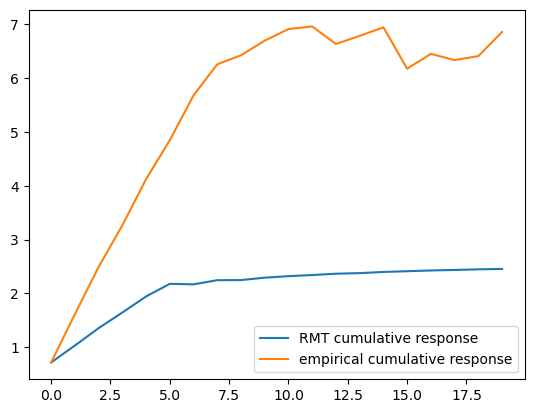

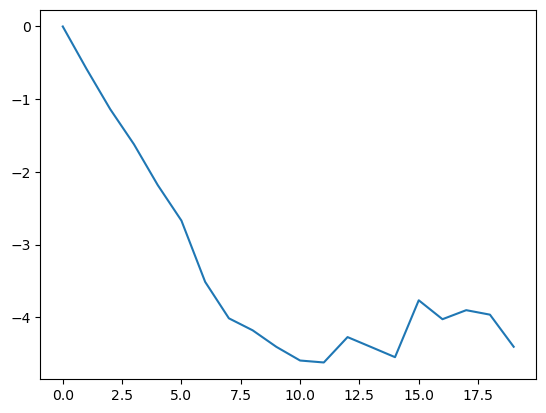

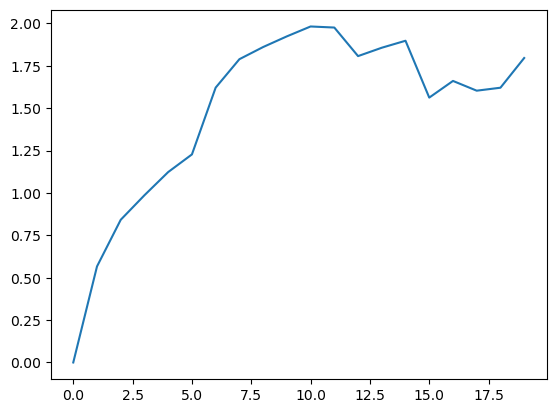

In [450]:
"""
This part of the code has been built at the end of my internship. The objective was to find the cumulative response,
that is the response from all nodes to all the others. I think that the fixed point formulation is more clear than the 
path I took in the part of code above. Still, the two methods are equivalents.
"""


def solve_fp_eq(C0th, alpha, rho, initial_guess, tol, max_iter):
    """
    Solve the fixed-point equation for the self-energy.

    Parameters:
    - C0th (ndarray): Population matrix.
    - alpha (float): Hyperparameter contained in the loss function.
    - rho (float): Inverse parameter of the Marchenko-Pastur distribution.
    - initial_guess (float): Initial guess for the self-energy.
    - tol (float): Tolerance for convergence.
    - max_iter (int): Maximum number of iterations.

    Returns:
    - tuple:
        - selfe_new (float): Converged self-energy value.
        - g_new (float): Converged value of g, which is the normalized trace of the resolvent.
        - eigen (ndarray): Eigenvalues of the covariance matrix.
    """
    selfe_old = initial_guess
    g_old = 0
    eigen = np.real(np.linalg.eigvals(C0th)) #real because population matrix is symmetric
    for i in range(max_iter):
        g_new = 0
        for eig in eigen :
            g_new += 1/len(eigen) * 1/(1+ selfe_old * eig)
        selfe_new = alpha * ( 1- 1/rho + g_new/rho)
        #print(selfe)
        if abs(selfe_new - selfe_old) < tol:
            print("g final =",g_new)
            print("selfenergy =", selfe_new)
            print("ratio self-energy / alpha =", selfe_new/alpha)
            return selfe_new, g_new, eigen
        selfe_old = selfe_new

def Q_lambda(eigen, selfe):
    """
    Calculate the function Q(lambda) using eigenvalues and self-energy.

    Parameters:
    - eigen (ndarray): Eigenvalues of the covariance matrix.
    - selfe (float): Self-energy value.

    Returns:
    - float: The value of Q(lambda).
    """
    g1 = 0
    g2 = 0
    for eig in eigen :
        g1 += 1/len(eigen) * 1/(1+ selfe * eig)
        g2 += 1/len(eigen) * 1/(1+selfe*eig)**2
    Q = 1 - 2 * g1 + g2
    print("Q=", Q)
    return Q

def dlambda_dalpha(alpha, selfe, rho, Q):
    """
    Compute the derivative of lambda with respect to alpha.

    Parameters:
    - alpha (float): Interaction strength parameter.
    - selfe (float): Self-energy value.
    - rho (float): Spectral radius of the system.
    - Q (float): Value of Q(lambda).

    Returns:
    - float: The derivative of lambda with respect to alpha.
    """
    return selfe**2 / alpha**2 * rho / (rho - Q)

def RMTempiricalresponse_full(Cth, R, rho, alpha, beta, Neff, d, time, sigma, initial_guess=None, tol=1e-12, max_iter=10000):
    """
    Compute the cumulative empirical response function using Random Matrix Theory.

    Parameters:
    - Cth (ndarray): Theoretical covariance matrix.
    - R (ndarray): System matrix.
    - rho (float): Spectral radius of the system.
    - alpha (float): Interaction strength parameter.
    - beta (float): Time scaling parameter.
    - Neff (float): Effective number of samples.
    - d (int): Dimension of the system.
    - time (int): Number of time steps.
    - sigma (float): Noise strength parameter.
    - initial_guess (float, optional): Initial guess for the fixed point iteration. Default is `alpha / 1000`.
    - tol (float): Tolerance for convergence.
    - max_iter (int): Maximum number of iterations.

    Returns:
    - tuple:
        - response (ndarray): The empirical response function.
        - bias (ndarray): The bias term matrix for each time step.
        - variance (ndarray): The variance term matrix for each time step.
    """
    if initial_guess is None:
        initial_guess = alpha / 1000
        
    fullresponse = np.zeros((beta*time,))
    bias = np.zeros((beta*time,))
    variance = np.zeros((beta * time,))
    
    smallR = newR(R,d, beta)
    selfe, g, spectrum = solve_fp_eq(Cth[0], alpha, rho, initial_guess, tol, max_iter)
    Q = Q_lambda(spectrum, selfe)
    G = resolvent(Cth[0], selfe,d)
    print('G',G)
    print('G^2', G @ G)
    print('G - G^2', G - G @ G)
    print( "np.trace(  (np.identity(d) -G) @ G)", np.trace(  (np.identity(d) -G) @ G))
    print("np.trace( G @ (np.identity(d) -G))", np.trace( G @ (np.identity(d) -G)))
    Rsumpower, Rlistpower = sumpower(smallR,beta * time,d)
    dl = dlambda_dalpha(alpha,selfe,rho,Q)
    print('dl=', dl)
    for t in range(beta*time):
        #print(Rsumpower[t])
        TrAAt = np.trace(Rlistpower[t] @ np.transpose(Rlistpower[t]))
        bias1 = TrAAt
        bias2 = - np.trace(Rlistpower[t] @ G @ np.transpose(Rlistpower[t]))
        bias3 =  - dl * np.trace (Rlistpower[t] @ G @ (np.identity(d) -G) @ np.transpose(Rlistpower[t]) )
        #bias2 = 0
        #bias3 = 0
        bias[t] = bias1 + bias2 + bias3
        print("biastot =",bias[t])
        if t == 0 :
            variance[t] = 0
        else:
            variance[t] = dl * np.trace(  (np.identity(d) -G) @ G) * np.trace(Rsumpower[t-1])
        print("t=",t)
        print("bias1=",bias1)
        print("bias2=",bias2)
        print("bias3=",bias3)
        print("variance",variance[t])
    variance =  alpha * sigma **2 / Neff  * variance
    print("prefactor =", alpha* sigma **2/ Neff)
    bias, variance = bias /(Nedges * d), variance / (Nedges*d) 
    response = bias + variance
    return(response,bias,variance)


def fullsum(Rt, d, time, beta):
    """
    Compute the cumulative empirical response function.

    Parameters:
    - Rt (ndarray): Time series of the cumulative empirical response function.
    - d (int): Dimension of the system.
    - time (int): Number of time steps.
    - beta (float): Time scaling parameter.

    Returns:
    - ndarray: The full sum of the empirical response.
    """
    empresponse = np.zeros((beta * time,))
    for t in range(beta * time):
        for i in range(d):
            for j in range(d):
                empresponse[t] += Rt[t, i, j]
    return empresponse

response, cumbias, cumvariance = RMTempiricalresponse_full(Cth, R, Neff / d, alpha, beta, Neff, d, time, sigma)
print(Neff / d)

plt.plot(response, label="RMT cumulative response")

empresponse = fullsum(RTcorr**2, d, time, beta)
empresponse = empresponse / (Nedges * d)

print("diff",response/empresponse)

plt.plot(empresponse, label="empirical cumulative response")
plt.legend()
plt.show()

plt.plot(response - empresponse)
plt.show()
plt.plot((abs(response - empresponse)) / response)


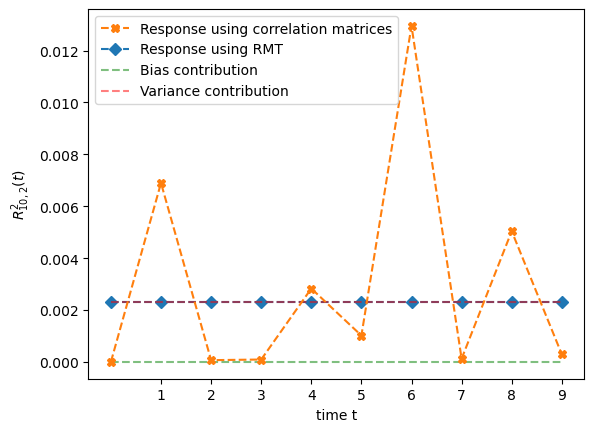

<Figure size 640x480 with 0 Axes>

In [438]:
def plotcomparisons(RTrmt, bias, variance, RTcorr, time, beta, d, i="random", j="random"):
    """
    Plots a comparison of response functions inferred using RMT 
    and empirical correlation matrices, along with contributions from bias and variance.

    Parameters:
    - RTrmt (ndarray): Theoretical response matrices.
    - bias (ndarray): Bias component matrices.
    - variance (ndarray): Variance component matrices.
    - RTcorr (ndarray): Response matrix using correlation matrices.
    - time (int): Total number of time steps.
    - beta (float): Time scaling parameter.
    - d (int): Dimension of the system.
    - i (int or str): Index of the first dimension for plotting. If "random", a random index is chosen. Default is "random".
    - j (int or str): Index of the second dimension for plotting. If "random", a random index is chosen. Default is "random".

    Returns:
    - None. The function generates and displays the plot.
    """
    xrange = np.arange(0, time, 1/beta)
    
    # Choose random indices if not specified
    if i == "random":
        i = np.random.randint(0, d)
    if j == "random":
        j = np.random.randint(0, d)

    # Plot the response functions and contributions
    line2, = plt.plot(xrange, RTrmt[:, i, j], linestyle="--", marker='D', label="Response using RMT")
    line3, = plt.plot(xrange, bias[:, i, j], linestyle="--", color='green', alpha=0.5, label="Bias contribution")
    line4, = plt.plot(xrange, variance[:, i, j], color='red', linestyle="--", alpha=0.5, label="Variance contribution")
    line1, = plt.plot(xrange, RTcorr[:, i, j], linestyle="--", marker="X", label="Response using correlation matrices")

    # Add legend, labels, and ticks
    plt.legend(handles=[line1, line2, line3, line4])
    plt.xticks(np.arange(1, time))
    plt.xlabel("time t")
    plt.ylabel(f'$R^2_{{{j},{i}}}(t)$')
    plt.show()
    #plt.title(f"Response function inferred by two different methods \n for alpha = {alpha}.")

    
# Execute the function with specified parameters
i = 3
j = 26
i = np.random.randint(0, d)
j = np.random.randint(0, d)
plotcomparisons(RTrmt, bias, variance, RTcorr**2,time,  beta, d, i, j)
plt.tight_layout()
#plt.savefig(f'link from {j} to {i} with D={d}, N={taverage}, average connectivity ={Nedges}')
plt.show()

In [ ]:
def checkforedges(R, d):
    """
    Identifies all edges present in a directed graph represented by an adjacency matrix.

    Parameters:
    - R (ndarray): Adjacency matrix.
    - d (int): Dimension of the matrix (number of nodes).

    Returns:
    - listedges (list of lists): A list containing two lists. The first list contains the source nodes of the edges, 
                                 and the second list contains the corresponding target nodes.
    """
    listedges = [[], []]
    for i in range(d):
        for j in range(d):
            if R[i, j] != 0 and i != j:
                listedges[0].append(i)
                listedges[1].append(j)
    return listedges

def checkforedges_one_node(R, i, d):
    """
    Identifies all edges outgoing from a specific node.

    Parameters:
    - R (ndarray): Adjacency matrix.
    - i (int): Index of the node for which outgoing edges are to be found.
    - d (int): Dimension of the matrix (number of nodes).

    Returns:
    - listedges (list): A list containing the indices of nodes that have an incoming edge from node `i`.
    """
    listedges = []
    for j in range(d):
        if R[i, j] != 0:
            listedges.append(j)
    return listedges

#a = checkforedges(np.linalg.matrix_power(R, 1),d )
#index = 4 # choose the index that you want
#print(a[0][index], a[1][index])

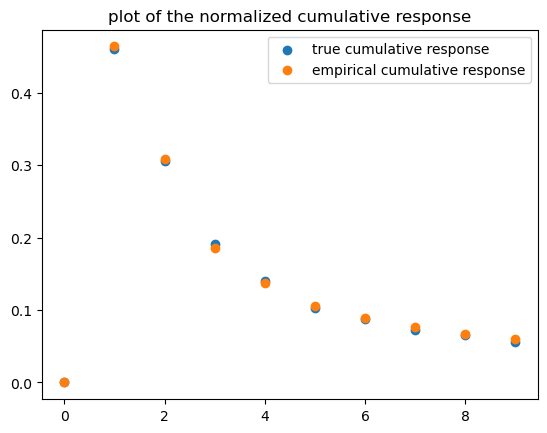

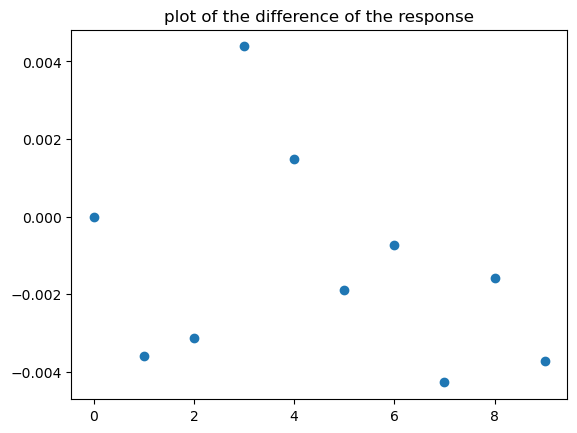

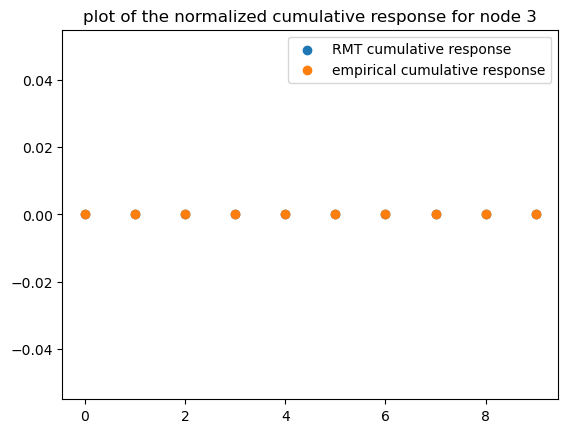

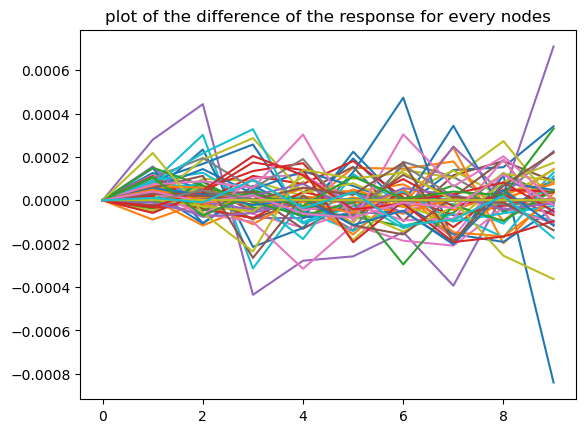

In [341]:
#Now, let us average over the whole graph, that is compute the response from all nodes to the others. In the first case, we'll do it only when a true causal link is present while in the second time, we will average over the whole response matrix. This should smoothen out the noise.

def cumulative_response(R, RTcorr, time, d, beta, Nedges, goodlinks = "true"):
    smallR = newR(R,d,beta)
    RTthcumulative = np.zeros((beta * time))
    RTcorrcumulative = np.zeros((beta * time))
    listofedges = np.zeros((beta * time,), dtype= object)
    Rpower = power(smallR,beta * time,d)
    if goodlinks =="true" :
        for t in range(1,beta * time):
            listofedges[t] = checkforedges(Rpower[t],d)
            for i in range(len(listofedges[t][0])):
                RTcorrcumulative[t] += RTcorr[t,listofedges[t][0][i], listofedges[t][1][i]]
                RTthcumulative[t] += Rpower[t][listofedges[t][0][i],listofedges[t][1][i]]
    else:
        for t in range(1,beta * time):
            for i in range(d):
                for j in range(d):
                    RTcorrcumulative[t] += RTcorr[t,i,j]
                    RTthcumulative[t] += Rpower[t][i,j]
    RTcorrcumulative = RTcorrcumulative / (Nedges * d)
    RTthcumulative = RTthcumulative / (Nedges * d)
    return(RTthcumulative, RTcorrcumulative)

Rtcum, Rtcorrcum = cumulative_response(R, RTcorr, time,d, beta, Nedges, goodlinks = "false")
   
xrange = np.arange(0, time, 1/beta)
plt.scatter(xrange,Rtcum, label = "true cumulative response") 
plt.scatter(xrange,Rtcorrcum, label = "empirical cumulative response")
plt.title("plot of the normalized cumulative response")
plt.legend()
plt.show()
plt.scatter(xrange, Rtcum-Rtcorrcum)
plt.title("plot of the difference of the response")
plt.show()

#The true cumulative response is a limit curve that can be attained by the empirical response only in the case where you have an infinite amount of measures.

#Let us check the response from one node to all of the others.

def cumulative_response_by_node(R, RTcorr, time, d, beta, Nedges, goodlinks = "false"):
    smallR = newR(R,d,beta)
    RTthcumulative = np.zeros((beta * time, d))
    RTcorrcumulative = np.zeros((beta * time, d))
    listofedges = np.zeros((beta * time,), dtype= object)
    Rpower = power(smallR,beta * time,d)
    if goodlinks =="true" :
        for i in range(d):
            for t in range(1,beta * time):
                listofedges[t] = checkforedges_one_node(Rpower[t], i, d)
                for j in range(len(listofedges[t])):
                    RTcorrcumulative[t,i] += RTcorr[t,i, listofedges[t][j]]
                    RTthcumulative[t,i] += Rpower[t][i,listofedges[t][j]]
    else:
        for t in range(1,beta * time):
            for i in range(d):
                for j in range(d):
                    RTcorrcumulative[t,i] += RTcorr[t,i,j]
                    RTthcumulative[t,i] += Rpower[t][i,j]
    RTcorrcumulative = RTcorrcumulative / (Nedges * d)
    RTthcumulative = RTthcumulative / (Nedges * d)
    return(RTthcumulative, RTcorrcumulative)

Rtcum, Rtcorrcum = cumulative_response_by_node(R, RTcorr, time,d, beta, Nedges, goodlinks = "true")
   
i = 3
xrange = np.arange(0, time, 1/beta)
plt.scatter(xrange,Rtcum[:,i], label = "RMT cumulative response") 
plt.scatter(xrange,Rtcorrcum[:,i], label = "empirical cumulative response")
plt.title(f"plot of the normalized cumulative response for node {i}")
plt.legend()
plt.show()
plt.title("plot of the difference of the response for every nodes")
plt.plot(xrange, Rtcum-Rtcorrcum)